In [7]:
import numpy as np
import matplotlib.pyplot as plt

class QLearningAgent:
    def __init__(self, num_actions, learning_rate=0.1, discount_factor=0.9, exploration_rate=1.0, exploration_decay=0.99):
        self.num_actions = num_actions
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_rate = exploration_rate
        self.exploration_decay = exploration_decay
        self.q_table = np.zeros((25, num_actions))

    def choose_action(self, state, policy):
        if policy == 'PRANDOM':
            return self.choose_action_prandom(state)
        elif policy == 'PEXPLOIT':
            return self.choose_action_pexploit(state)
        elif policy == 'PGREEDY':
            return self.choose_action_pgreedy(state)

    def choose_action_prandom(self, state):
        if np.random.rand() < self.exploration_rate:
            return np.random.randint(self.num_actions)
        else:
            return np.argmax(self.q_table[state])

    def choose_action_pexploit(self, state):
        if np.random.rand() < self.exploration_rate:
            if np.random.rand() < 0.8:
                return np.argmax(self.q_table[state])
            else:
                return np.random.choice(np.where(self.q_table[state] == np.max(self.q_table[state]))[0])
        else:
            return np.argmax(self.q_table[state])

    def choose_action_pgreedy(self, state):
        return np.argmax(self.q_table[state])

    def update_q_table(self, state, action, reward, next_state):
        old_q_value = self.q_table[state, action]
        max_next_q_value = np.max(self.q_table[next_state])
        new_q_value = old_q_value + self.learning_rate * (reward + self.discount_factor * max_next_q_value - old_q_value)
        self.q_table[state, action] = new_q_value

    def decay_exploration_rate(self):
        self.exploration_rate *= self.exploration_decay

In [8]:
class SARSAQAgent(QLearningAgent):
    def update_q_table(self, state, action, reward, next_state, next_action=None):
        if next_action is None:
            raise ValueError("Next action must be provided for SARSA")
        old_q_value = self.q_table[state, action]
        next_q_value = self.q_table[next_state, next_action]
        new_q_value = old_q_value + self.learning_rate * (reward + self.discount_factor * next_q_value - old_q_value)
        self.q_table[state, action] = new_q_value


    def choose_action(self, state, policy):
        if policy == 'PRANDOM':
            return self.choose_action_prandom(state)
        elif policy == 'PEXPLOIT':
            return self.choose_action_pexploit(state)
        elif policy == 'PGREEDY':
            return self.choose_action_pgreedy(state)
        elif policy == 'SARSA':
            return self.choose_action_sarsa(state)

    def choose_action_sarsa(self, state):
        if np.random.rand() < self.exploration_rate:
            return np.random.randint(self.num_actions)
        else:
            return np.argmax(self.q_table[state])

In [9]:
class Environment:
    def __init__(self):
        self.grid_size = 5
        self.num_agents = 3
        self.pickup_locations = [(1, 5), (2, 4), (5, 2)]  
        self.dropoff_locations = [(1, 1), (3, 1), (4, 5)] 
        self.agent_locations = [(3, 3), (5, 3), (1, 3)]
        self.agent_colors = ['red', 'blue', 'black']  # Assign colors to agents
        self.agent_blocks = [0, 0, 0]
        self.blocks_at_pickup = [5, 5, 5]
        self.max_blocks_at_dropoff = 5
        self.paths = [[] for _ in range(self.num_agents)]  # List to store paths taken by agents

    def reset(self):
        self.agent_locations = [(3, 3), (5, 3), (1, 3)]
        self.agent_blocks = [0, 0, 0]
        self.blocks_at_pickup = [5, 5, 5]
        self.paths = [[] for _ in range(self.num_agents)]

    def get_state(self, agent_id):
        agent_loc = self.agent_locations[agent_id]
        return (agent_loc[0] - 1) * (self.grid_size - 1) + (agent_loc[1] - 1)  

    def move_agent(self, agent_id, action):
        current_loc = self.agent_locations[agent_id]
        new_loc = current_loc

        if action == 0:  # Up
            new_loc = (max(current_loc[0] - 1, 1), current_loc[1])
        elif action == 1:  # Down
            new_loc = (min(current_loc[0] + 1, self.grid_size), current_loc[1])
        elif action == 2:  # Left
            new_loc = (current_loc[0], max(current_loc[1] - 1, 1))
        elif action == 3:  # Right
            new_loc = (current_loc[0], min(current_loc[1] + 1, self.grid_size))

        # Check for collision with other agents
        if new_loc in self.agent_locations:
            # If the new location is already occupied, stay in the current position
            new_loc = current_loc

        self.agent_locations[agent_id] = new_loc
        self.paths[agent_id].append(new_loc)  # Record the path taken by the agent

        reward = -1
        if new_loc in self.pickup_locations:
            pickup_index = self.pickup_locations.index(new_loc)
            if self.blocks_at_pickup[pickup_index] > 0 and self.agent_blocks[agent_id] == 0:
                reward += 13
                self.blocks_at_pickup[pickup_index] -= 1
                self.agent_blocks[agent_id] += 1
        elif new_loc in self.dropoff_locations:
            dropoff_index = self.dropoff_locations.index(new_loc)
            if self.agent_blocks[agent_id] > 0 and self.agent_blocks[agent_id] < self.max_blocks_at_dropoff:
                reward += 13
                self.agent_blocks[agent_id] -= 1

        return reward

In [10]:
def train_agents(env, agents, num_iterations, policy):
    for _ in range(2):  # Run each experiment twice
        for iteration in range(num_iterations):
            env.reset()  # Reset the PD world to initial state
            for agent_id in range(env.num_agents):
                agent = agents[agent_id]
                state = env.get_state(agent_id)
                total_reward = 0
                action = None  # Initialize action for SARSA

                for _ in range(100):  
                    if policy == 'SARSA':
                        next_action = agent.choose_action(state, policy)  # Get next action for SARSA
                    action = agent.choose_action(state, policy)  # Get action for Q-learning or SARSA
                    reward = env.move_agent(agent_id, action)
                    next_state = env.get_state(agent_id)
                    total_reward += reward
                    if policy == 'SARSA':
                        agent.update_q_table(state, action, reward, next_state, next_action)  # Provide next_action for SARSA
                    else:
                        agent.update_q_table(state, action, reward, next_state)
                    state = next_state
                    if total_reward > 0:  
                        break

                agent.decay_exploration_rate()

            if iteration % 100 == 0:
                print("Experiment:", _ + 1, "Iteration:", iteration)

In [11]:
def plot_q_table_heatmap(q_table):
    plt.figure(figsize=(10, 6))
    plt.imshow(q_table, cmap='viridis', aspect='auto')
    plt.colorbar()
    plt.xlabel('Actions')
    plt.ylabel('States')
    plt.title('Q-Table Heatmap')
    plt.show()

Experiment 1:
Experiment: 6 Iteration: 0
Experiment: 2 Iteration: 100
Experiment: 2 Iteration: 200
Experiment: 2 Iteration: 300
Experiment: 2 Iteration: 400
Experiment: 2 Iteration: 0
Experiment: 2 Iteration: 100
Experiment: 2 Iteration: 200
Experiment: 2 Iteration: 300
Experiment: 2 Iteration: 400
Experiment: 2 Iteration: 0
Experiment: 2 Iteration: 100
Experiment: 2 Iteration: 200
Experiment: 2 Iteration: 300
Experiment: 2 Iteration: 400
Experiment: 2 Iteration: 500
Experiment: 2 Iteration: 600
Experiment: 2 Iteration: 700
Experiment: 2 Iteration: 800
Experiment: 2 Iteration: 900
Experiment: 2 Iteration: 1000
Experiment: 2 Iteration: 1100
Experiment: 2 Iteration: 1200
Experiment: 2 Iteration: 1300
Experiment: 2 Iteration: 1400
Experiment: 2 Iteration: 1500
Experiment: 2 Iteration: 1600
Experiment: 2 Iteration: 1700
Experiment: 2 Iteration: 1800
Experiment: 2 Iteration: 1900
Experiment: 2 Iteration: 2000
Experiment: 2 Iteration: 2100
Experiment: 2 Iteration: 2200
Experiment: 2 Iteratio

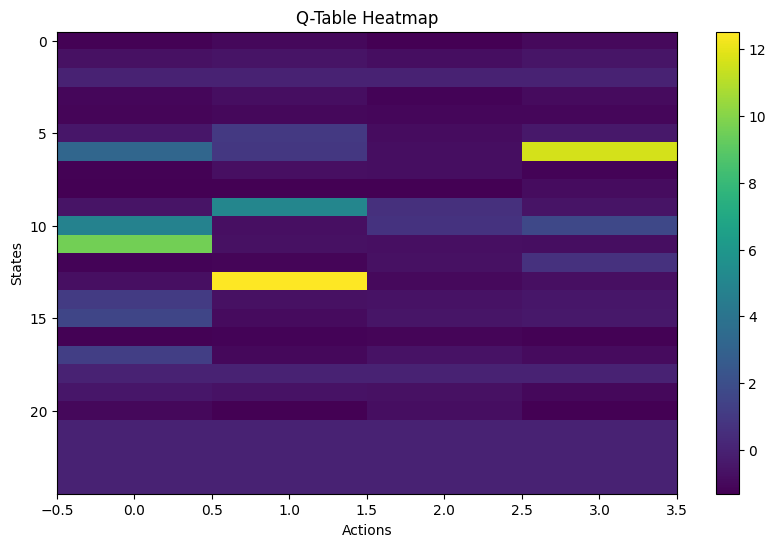

Agent 1 (Color: blue) Q-table:
[[-1.77254722 -1.77068351 -1.76336229 -1.77475851]
 [-1.75185895 -1.76697108 -1.78064941 -1.74839006]
 [ 0.          0.          0.          0.        ]
 [-1.68718338 -1.67698343 -1.67067839 -1.64168771]
 [-1.78923306 -1.78473277 -1.76253831 -1.78174465]
 [-1.76267026 -1.75497611 -1.74806719 -1.72775561]
 [-1.74322912 -1.75415142 -1.77256793 -1.75908667]
 [-1.64349462 -0.8174122  -1.63035529 -1.66334098]
 [-1.82677753 -1.80901825 -1.81334435 -1.80753432]
 [-1.77153647 -1.77290871 -1.7713189  -1.71794525]
 [-1.74648552 -1.77752307 -1.73915464 -1.75608779]
 [-1.7764194  -1.80206613 -1.77902772 -1.79117908]
 [ 2.0519427  -1.83915112 -1.83600399 -1.83877488]
 [-1.80852503 -1.81443685 -1.83925223 -1.82332276]
 [-1.8107056   1.44946498 -1.80778678 -1.83214478]
 [-1.798069   -1.82121659 -1.75288518 -1.78824634]
 [-1.86428903 -1.87323872 -1.87440929 -1.8608888 ]
 [-1.77325346 -1.75612872 -1.7696626  -1.74566351]
 [-1.54614374 -1.85794444 11.12716825 -1.89773278]


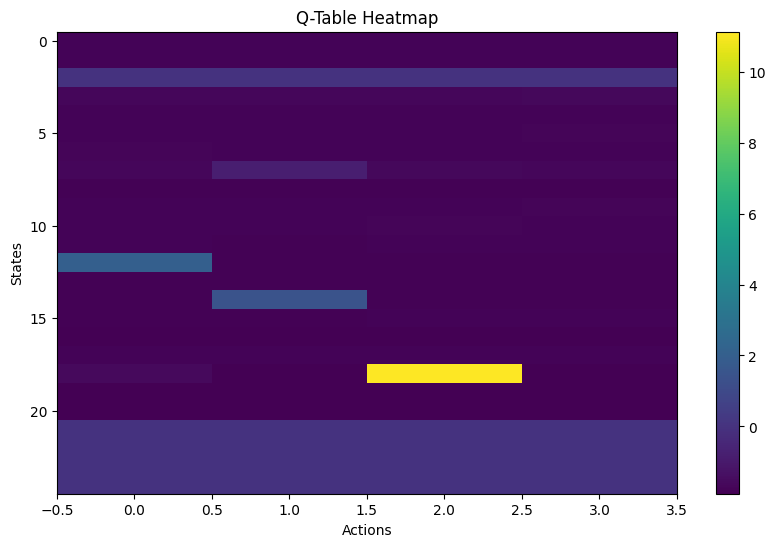

Agent 2 (Color: black) Q-table:
[[-1.33484978 -1.17921535 -1.32412921 -1.14563795]
 [-1.18832023 -1.2111821  -1.32843416  0.99592033]
 [-0.37298378 -1.26100204 -0.9848451   5.32006697]
 [-1.09909073  4.45011357 -1.14095554 12.64013393]
 [-1.44294456 -0.82756161  1.28026787 -1.4302189 ]
 [-0.98816197 -0.96099946 -1.02728449 -0.78129947]
 [ 0.26626656 -1.2367557  -1.33293276 -1.20244043]
 [ 0.06668052 -0.30692741 -0.47862308 -1.35201904]
 [-0.17170697 -1.455374   -1.3128776  -1.21204212]
 [-1.33228641 -1.15302973 -1.2415166  -1.27105374]
 [-1.13869056 -1.10982108 -1.26425182 -1.16348263]
 [-1.22812952 -1.46793086 -1.28464684 -1.35169635]
 [-0.96191873 -1.49933197 -1.49128385 -1.53695031]
 [-1.32243822 -1.27585989 -1.27148383 -1.39541417]
 [-1.37270593 -1.37730563 -1.35924136 -1.35376633]
 [-1.33176343 -1.25695337 -1.31697504 -1.30997326]
 [-1.46007899 -1.55827204 -1.47353107 -1.49986345]
 [-0.56068867  0.          0.17773535 -0.4053    ]
 [-1.37669965 -1.26681009 -1.32513621 -1.24613347]

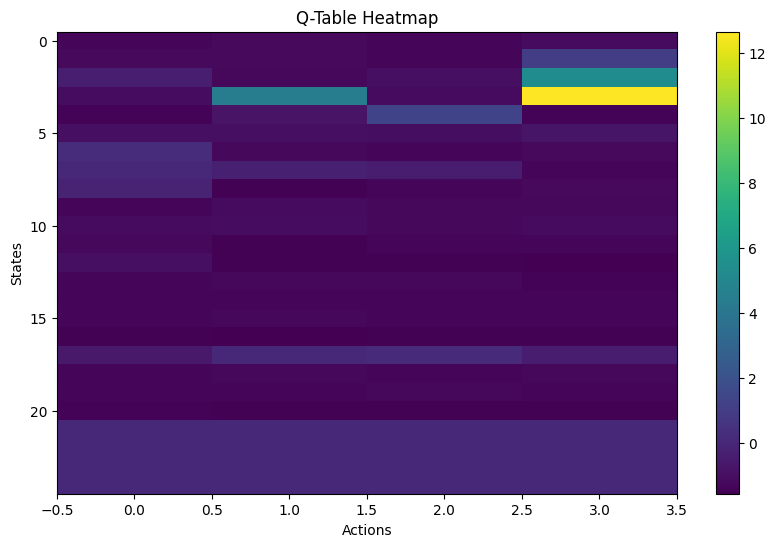

In [12]:
env = Environment()
agents = [QLearningAgent(num_actions=4, learning_rate=0.3, discount_factor=0.5) for _ in range(env.num_agents)]

# Experiment 1
print("Experiment 1:")
train_agents(env, agents, num_iterations=500, policy='PRANDOM')  # Initial training with PRANDOM for 500 steps

# Switch policy to PRANDOM and continue training for 8500 steps
train_agents(env, agents, num_iterations=8500, policy='PRANDOM')

# Switch policy to PGREEDY and continue training for 8500 steps
train_agents(env, agents, num_iterations=8500, policy='PGREEDY')

# Switch policy to PEXPLOIT and continue training for 8500 steps
train_agents(env, agents, num_iterations=8500, policy='PEXPLOIT')

# After training for "PEXPLOIT" policy
print("Q-table for PEXPLOIT policy:")
for agent_id, agent in enumerate(agents):
    agent_color = env.agent_colors[agent_id]  # Get the color of the current agent
    print(f"Agent {agent_id} (Color: {agent_color}) Q-table:")
    print(agent.q_table)
    plot_q_table_heatmap(agent.q_table)

Experiment 2 with Q-learning:
Experiment: 100 Iteration: 0
Experiment: 2 Iteration: 100
Experiment: 2 Iteration: 200
Experiment: 2 Iteration: 300
Experiment: 2 Iteration: 400
Experiment: 2 Iteration: 500
Experiment: 2 Iteration: 600
Experiment: 2 Iteration: 700
Experiment: 2 Iteration: 800
Experiment: 2 Iteration: 900
Experiment: 2 Iteration: 1000
Experiment: 2 Iteration: 1100
Experiment: 2 Iteration: 1200
Experiment: 2 Iteration: 1300
Experiment: 2 Iteration: 1400
Experiment: 2 Iteration: 1500
Experiment: 2 Iteration: 1600
Experiment: 2 Iteration: 1700
Experiment: 2 Iteration: 1800
Experiment: 2 Iteration: 1900
Experiment: 2 Iteration: 2000
Experiment: 2 Iteration: 2100
Experiment: 2 Iteration: 2200
Experiment: 2 Iteration: 2300
Experiment: 2 Iteration: 2400
Experiment: 2 Iteration: 2500
Experiment: 2 Iteration: 2600
Experiment: 2 Iteration: 2700
Experiment: 2 Iteration: 2800
Experiment: 2 Iteration: 2900
Experiment: 2 Iteration: 3000
Experiment: 2 Iteration: 3100
Experiment: 2 Iterat

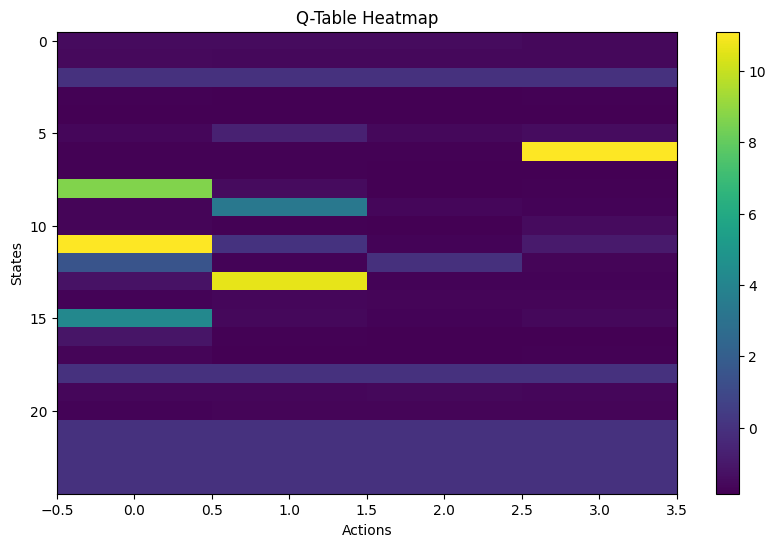

Agent 1 (Color: blue) Q-table:
[[-1.97564184 -1.97387654 -1.9777608  -1.97538319]
 [-1.9723579  -1.97325097  1.9238751  -1.97316202]
 [ 0.          0.          0.          0.        ]
 [-1.9928514  -1.99167714 -1.99218649 -1.99287337]
 [-1.99162029 -1.9914647  -1.99242879 -1.99270162]
 [-1.97447548 -1.97637871 -1.97255829 -1.97204569]
 [-1.98541804 -1.9853073  -1.98428324 -1.9860152 ]
 [-1.98530007 -1.98536903 -1.98371509 -1.98446789]
 [-1.98667493 -1.98851676 -1.98714927 -1.98782801]
 [-1.98082796 -1.45834322 -1.98176742 -1.98285889]
 [-1.98507983 -1.98663903 -1.98428602 -1.98580506]
 [-1.98846785 -1.98888937 -1.98896093 -1.98827644]
 [ 2.07601321 -1.98769186 -1.98809207 -1.98679942]
 [-1.98193622 -1.98381345 -1.98503987 -1.98124196]
 [-1.98413713 -1.98506426 -1.98606494 -1.98523019]
 [-1.98732978 -1.98635236 -1.98760488 -0.65549099]
 [-1.40677915 -1.99158199 -1.99160593 -1.99144885]
 [-1.9898026  -1.99098259 -1.99020393 -1.99064837]
 [-1.98820731 -0.0413643  11.00489804 -1.99008871]


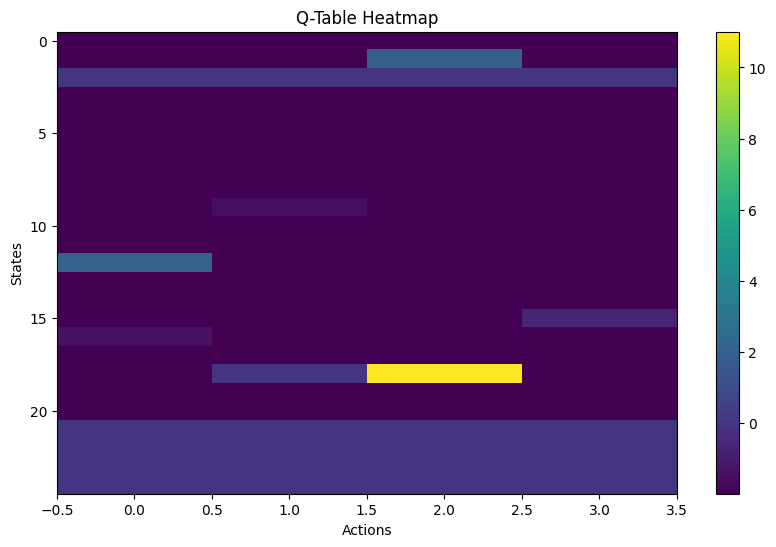

Agent 2 (Color: black) Q-table:
[[-1.93269021 -1.93439408 -1.92889249 -1.93349368]
 [-1.77191172 -1.93910139 -1.9401226   0.31053025]
 [-1.52099622 -1.77149449 -1.35648853  4.5144174 ]
 [ 2.46563564  0.3803895   0.3326184  11.0288348 ]
 [-1.93571611 -1.96185082 -1.8777143  -1.94233039]
 [-1.92341461 -1.94138946 -1.94000146 -1.9445118 ]
 [-1.59316804 -1.93699463 -1.96121948 -1.9075959 ]
 [-1.32480097 -1.35835584 -1.48720037 -1.3228982 ]
 [-1.93992624 -1.94566522 -1.72345945 -1.94422406]
 [-1.95640603 -1.93507779 -1.92380669 -1.9249025 ]
 [-1.91151227 -1.90346106 -1.91367223 -1.92578152]
 [-1.72598144 -1.93397161 -1.93432665 -1.95222757]
 [-1.959093   -1.96008306 -1.9657723  -1.96599158]
 [-1.95144994 -1.95720432 -1.95256542 -1.9605122 ]
 [-1.93406221 -1.94394027 -1.9571719  -1.95128873]
 [-1.95018962 -1.94881171 -1.95463339 -1.95263723]
 [-1.97078816 -1.95262272 -1.96343296 -1.9581085 ]
 [-1.77254651 -1.78791117 -1.3764201  -1.85753075]
 [-1.95415877 -1.94528172 -1.92836071 -1.93530028]

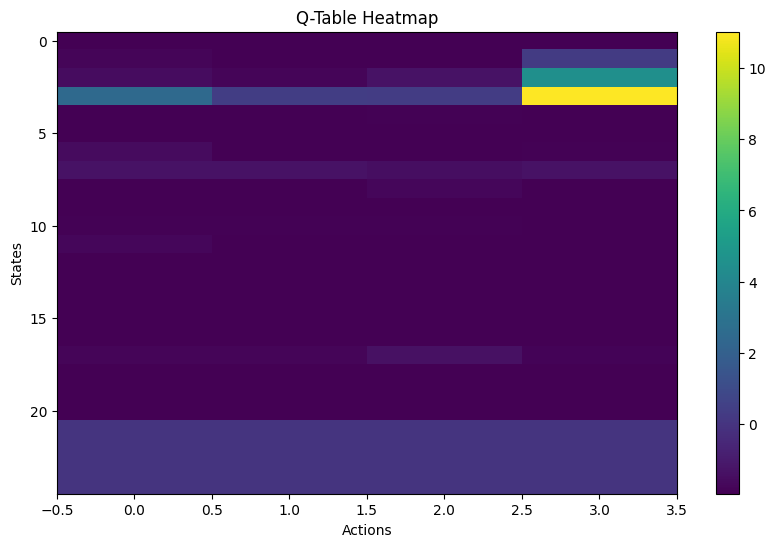

In [13]:
env = Environment()
q_learning_agents = [QLearningAgent(num_actions=4, learning_rate=0.3, discount_factor=0.5) for _ in range(env.num_agents)]
sarsa_agents = [SARSAQAgent(num_actions=4, learning_rate=0.3, discount_factor=0.5) for _ in range(env.num_agents)]

# Experiment 2 with Q-learning
print("Experiment 2 with Q-learning:")
train_agents(env, q_learning_agents, num_iterations=9000, policy='PGREEDY')

# Experiment 2 with SARSA
print("Experiment 2 with SARSA:")
train_agents(env, sarsa_agents, num_iterations=9000, policy='SARSA')

# Printing Q-table for SARSA
print("Q-table for SARSA policy:")
for agent_id, agent in enumerate(sarsa_agents):
    agent_color = env.agent_colors[agent_id]  # Get the color of the current agent
    print(f"Agent {agent_id} (Color: {agent_color}) Q-table:")
    print(agent.q_table)
    plot_q_table_heatmap(agent.q_table)

Experiment 3 with Q-learning (Learning Rate: 0.15):
Experiment: 100 Iteration: 0
Experiment: 2 Iteration: 100
Experiment: 2 Iteration: 200
Experiment: 2 Iteration: 300
Experiment: 2 Iteration: 400
Experiment: 2 Iteration: 500
Experiment: 2 Iteration: 600
Experiment: 2 Iteration: 700
Experiment: 2 Iteration: 800
Experiment: 2 Iteration: 900
Experiment: 2 Iteration: 1000
Experiment: 2 Iteration: 1100
Experiment: 2 Iteration: 1200
Experiment: 2 Iteration: 1300
Experiment: 2 Iteration: 1400
Experiment: 2 Iteration: 1500
Experiment: 2 Iteration: 1600
Experiment: 2 Iteration: 1700
Experiment: 2 Iteration: 1800
Experiment: 2 Iteration: 1900
Experiment: 2 Iteration: 2000
Experiment: 2 Iteration: 2100
Experiment: 2 Iteration: 2200
Experiment: 2 Iteration: 2300
Experiment: 2 Iteration: 2400
Experiment: 2 Iteration: 2500
Experiment: 2 Iteration: 2600
Experiment: 2 Iteration: 2700
Experiment: 2 Iteration: 2800
Experiment: 2 Iteration: 2900
Experiment: 2 Iteration: 3000
Experiment: 2 Iteration: 310

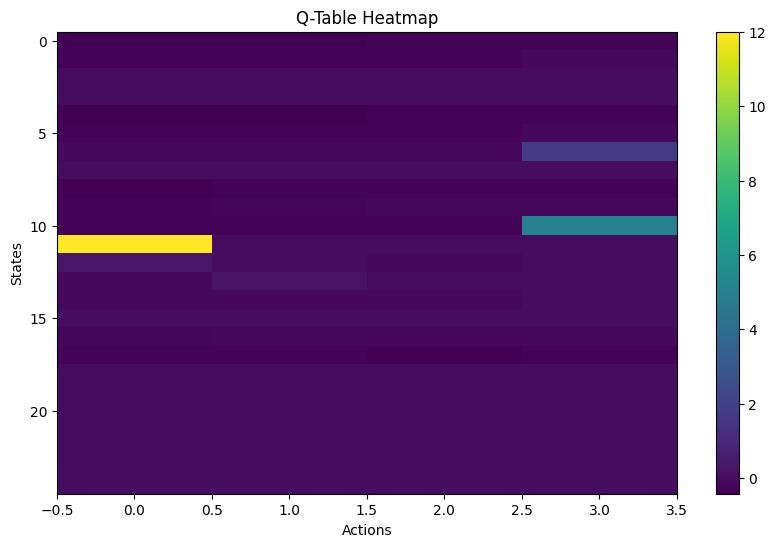

Agent 1 (Color: blue) Q-table:
[[-0.53581172 -0.40413437 -0.41709375 -0.41709375]
 [-0.41709375 -0.41625    -0.44369297 -0.41709375]
 [ 0.          0.          0.          0.        ]
 [-0.15       -0.15       -0.15       -0.17978437]
 [ 0.95750351 -0.53581172 -0.53581172 -0.53503125]
 [-0.40753125 -0.41625    -0.44297578 -0.4066875 ]
 [-0.41709375 -0.397125   -0.42593906 -0.3954375 ]
 [-0.2775     -0.18861318 -0.31756406 -0.18050156]
 [-0.5092125  -0.51097753 -0.51740391 -0.52618594]
 [-0.40896562 -0.2775     -0.30824063 -0.28875   ]
 [-0.28875    -0.2775     -0.28883437 -0.28875   ]
 [ 0.37602921 -0.15       -0.16125    -0.27710819]
 [-0.16775718 -0.28875    -0.19166124 -0.28875   ]
 [-0.15       -0.15       -0.11705597  0.        ]
 [-0.28875    -0.15       -0.15       -0.15      ]
 [-0.2775     -0.28875    -0.15       -0.15      ]
 [-0.28875    -0.28875    -0.28875    -0.15      ]
 [-0.15       -0.15       -0.15        0.        ]
 [-0.28875    -0.28875    12.         -0.2775    ]


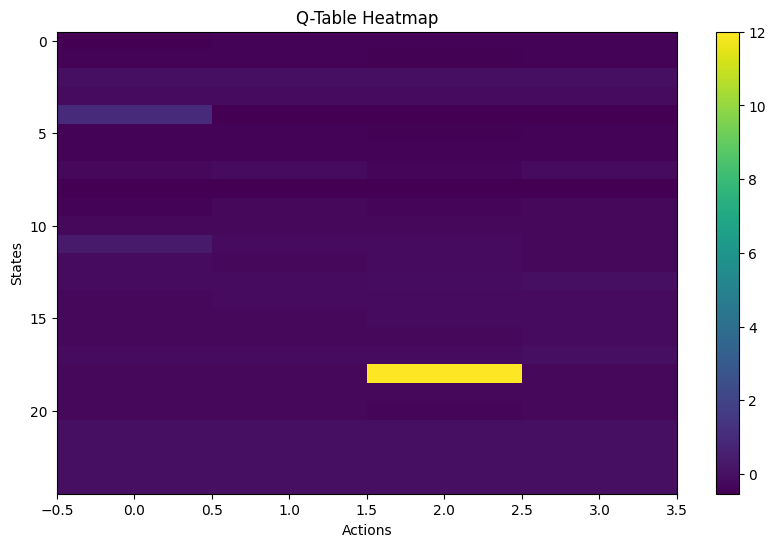

Agent 2 (Color: black) Q-table:
[[-0.41709375 -0.32569219 -0.41709375 -0.42522187]
 [-0.41709375 -0.5092125  -0.41709375 -0.42437812]
 [-0.53581172 -0.5092125  -0.52546875  4.84710715]
 [-0.15       -0.15       -0.16125    11.69421431]
 [-0.61157139 -0.70599853 -0.63599183 -0.61880672]
 [-0.41709375 -0.5092125  -0.45868821 -0.41709375]
 [-0.41625    -0.51734062 -0.42063729 -0.41709375]
 [ 0.          0.          0.          0.        ]
 [-0.55145295 -0.588598   -0.53581172 -0.53275312]
 [-0.41709375 -0.4900875  -0.44362969 -0.41709375]
 [-0.42593906 -0.4066875  -0.41930859 -0.40888531]
 [-0.31585635 -0.29703281 -0.29915625 -0.35076604]
 [-0.43556484 -0.31006431 -0.41480826 -0.40753125]
 [-0.30871875 -0.41709375 -0.42543979 -0.30871875]
 [-0.41715703 -0.411675   -0.41709375 -0.28875   ]
 [-0.38262188 -0.42593906 -0.42553266 -0.30594497]
 [-0.62554197 -0.60376969 -0.61819711 -0.53581172]
 [ 0.          0.          0.          0.        ]
 [-0.40620937 -0.41709375 -0.38808307 -0.43390508]

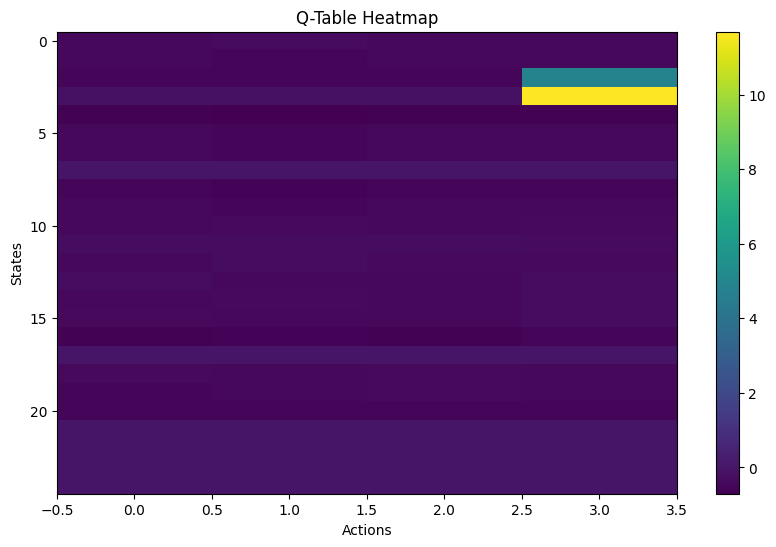

Experiment 3 with Q-learning (Learning Rate: 0.45):
Experiment: 100 Iteration: 0
Experiment: 2 Iteration: 100
Experiment: 2 Iteration: 200
Experiment: 2 Iteration: 300
Experiment: 2 Iteration: 400
Experiment: 2 Iteration: 500
Experiment: 2 Iteration: 600
Experiment: 2 Iteration: 700
Experiment: 2 Iteration: 800
Experiment: 2 Iteration: 900
Experiment: 2 Iteration: 1000
Experiment: 2 Iteration: 1100
Experiment: 2 Iteration: 1200
Experiment: 2 Iteration: 1300
Experiment: 2 Iteration: 1400
Experiment: 2 Iteration: 1500
Experiment: 2 Iteration: 1600
Experiment: 2 Iteration: 1700
Experiment: 2 Iteration: 1800
Experiment: 2 Iteration: 1900
Experiment: 2 Iteration: 2000
Experiment: 2 Iteration: 2100
Experiment: 2 Iteration: 2200
Experiment: 2 Iteration: 2300
Experiment: 2 Iteration: 2400
Experiment: 2 Iteration: 2500
Experiment: 2 Iteration: 2600
Experiment: 2 Iteration: 2700
Experiment: 2 Iteration: 2800
Experiment: 2 Iteration: 2900
Experiment: 2 Iteration: 3000
Experiment: 2 Iteration: 310

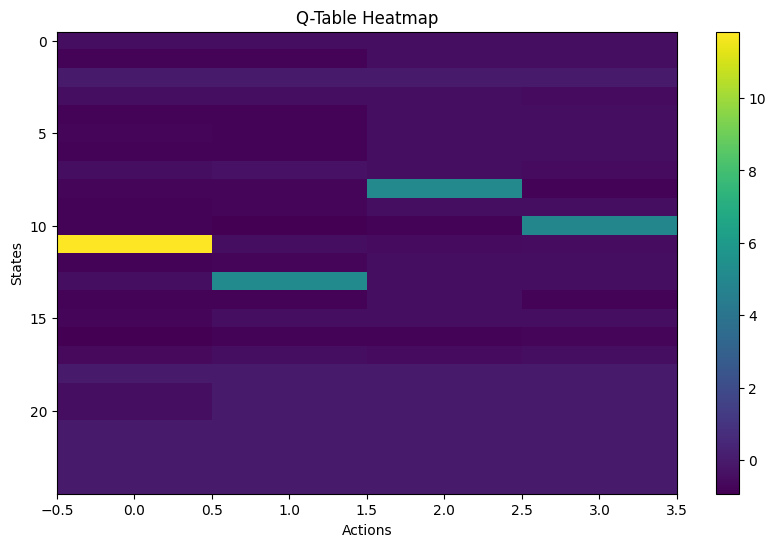

Agent 1 (Color: blue) Q-table:
[[-0.45       -0.45        0.          0.        ]
 [-0.45       -0.45        0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [-0.79875    -0.79875    -0.79875    -0.55125   ]
 [-0.79875    -0.79875    -0.79875    -0.45      ]
 [-0.45       -0.45       -0.45       -0.45      ]
 [-0.45       -0.45       -0.45       -0.45      ]
 [-0.6975     -0.6975     -0.45       -0.63187661]
 [-0.79875    -0.79875    -0.77401758 -0.45      ]
 [-0.45       -0.45       -0.55125    -0.45      ]
 [-0.45       -0.55125    -0.45        0.        ]
 [-0.45       -0.45        0.         -0.55125   ]
 [-0.6975     -0.79875    -0.45       -0.45      ]
 [-0.6975     -0.45       -0.45       -0.45      ]
 [-0.6975     -0.79875    -0.79875    -0.45      ]
 [-0.45       -0.79875    -0.55125    -0.45      ]
 [-0.79875    -0.79875    -0.55125     5.1525    ]
 [ 0.          0.          0.          0.        ]
 [-0.934875   -0.79875    12.         -0.934875  ]


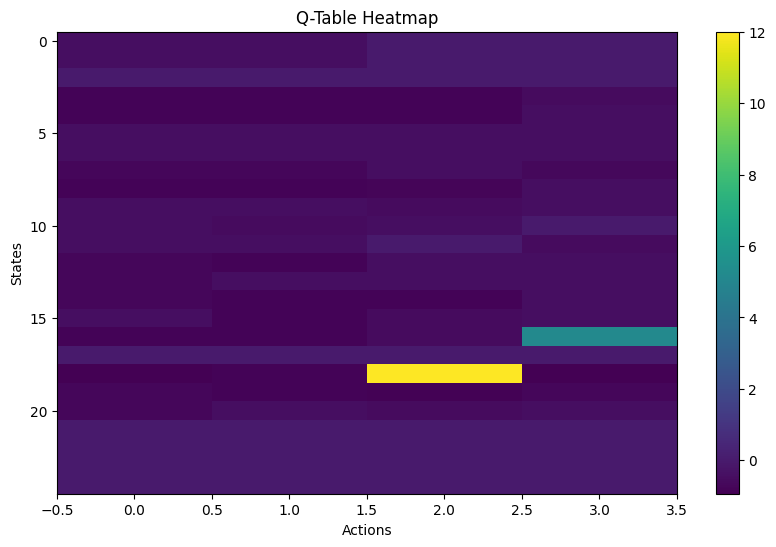

Agent 2 (Color: black) Q-table:
[[-0.79875    -0.6975     -0.45       -0.45      ]
 [-0.79875    -0.79875     5.1525     -0.45      ]
 [-0.79875    -0.79875    -0.79875     4.8875    ]
 [-0.45       -0.33062789 -0.55125    11.775     ]
 [-0.55125    -0.79875    -0.45       -0.45      ]
 [-0.79875    -0.79875    -0.45       -0.45      ]
 [-0.79875    -0.45       -0.45       -0.45      ]
 [-0.33068475 -0.45       -0.45       -0.45      ]
 [-0.79875    -0.934875   -0.79875    -0.6975    ]
 [-0.79875    -0.6975     -0.79875    -0.45      ]
 [ 0.          0.          0.          0.        ]
 [-0.45       -0.45        0.          0.        ]
 [-0.79875    -0.6975     -0.79875    -0.79875   ]
 [-0.79875    -0.79875    -0.55125    -0.6975    ]
 [-0.79875    -0.6975     -0.55125    -0.45      ]
 [-0.45       -0.45       -0.45        0.        ]
 [-0.79875    -0.45       -0.45       -0.45      ]
 [ 0.          0.          0.          0.        ]
 [-0.55125    -0.45        0.          0.        ]

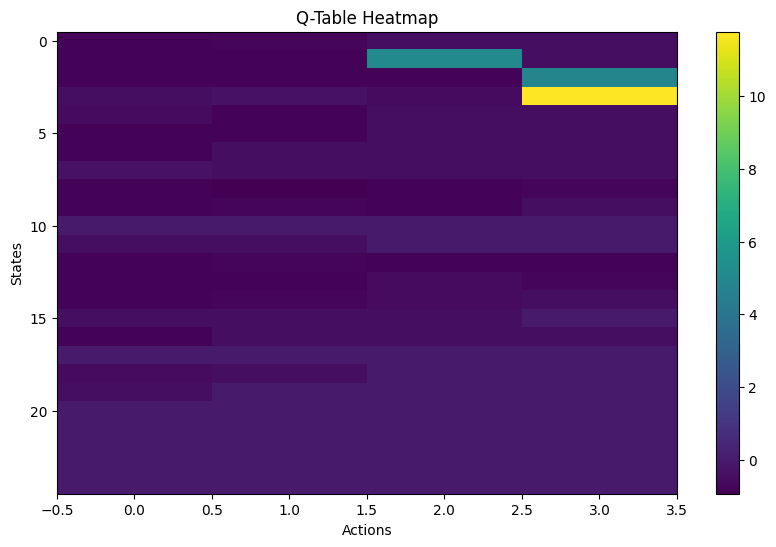

Experiment 3 with SARSA (Learning Rate: 0.15):
Experiment: 4 Iteration: 0
Experiment: 2 Iteration: 100
Experiment: 2 Iteration: 200
Experiment: 2 Iteration: 300
Experiment: 2 Iteration: 400
Experiment: 2 Iteration: 500
Experiment: 2 Iteration: 600
Experiment: 2 Iteration: 700
Experiment: 2 Iteration: 800
Experiment: 2 Iteration: 900
Experiment: 2 Iteration: 1000
Experiment: 2 Iteration: 1100
Experiment: 2 Iteration: 1200
Experiment: 2 Iteration: 1300
Experiment: 2 Iteration: 1400
Experiment: 2 Iteration: 1500
Experiment: 2 Iteration: 1600
Experiment: 2 Iteration: 1700
Experiment: 2 Iteration: 1800
Experiment: 2 Iteration: 1900
Experiment: 2 Iteration: 2000
Experiment: 2 Iteration: 2100
Experiment: 2 Iteration: 2200
Experiment: 2 Iteration: 2300
Experiment: 2 Iteration: 2400
Experiment: 2 Iteration: 2500
Experiment: 2 Iteration: 2600
Experiment: 2 Iteration: 2700
Experiment: 2 Iteration: 2800
Experiment: 2 Iteration: 2900
Experiment: 2 Iteration: 3000
Experiment: 2 Iteration: 3100
Exper

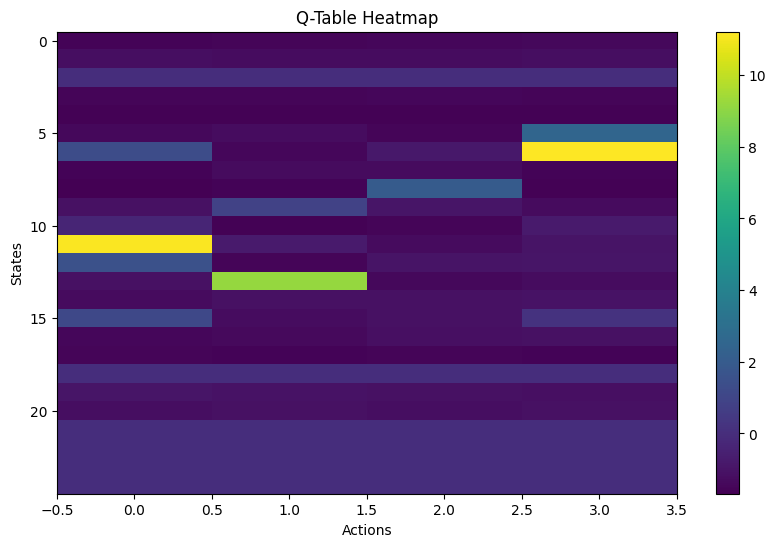

Agent 1 (Color: blue) Q-table:
[[-1.76551672 -1.7722279  -1.77296974 -1.76929432]
 [-1.67524839 -1.67968233 -1.66932047 -1.66908367]
 [ 0.          0.          0.          0.        ]
 [-1.90506326 -1.90627786 -1.90208531 -1.90743266]
 [-1.91231762 -1.90896013 -1.90934713 -1.90906582]
 [-1.61572616 -1.57864197 -1.76562108 -1.60658549]
 [-1.68931266 -1.69210674 -1.67614394 -1.6852923 ]
 [-1.78062759 -1.74793669 -1.75249747 -1.75354968]
 [ 0.4218153  -1.82091338 -1.81622381 -1.82161025]
 [-1.79922183 -1.152981   -1.67017878 -1.63862577]
 [-1.66430695 -1.66841109 -1.66664878 -1.68722669]
 [-1.7483235  -1.76013269 -1.75002277 -1.74854119]
 [-0.7968765  -1.78141555 -1.79292712 -1.77868274]
 [-1.74136067 -1.74112434 -1.74032132 -1.75200814]
 [-1.74260319 -1.73090197 -1.73008084 -1.74320625]
 [-1.74909494 -1.74286722 -1.74645514 -0.12864417]
 [-1.69107103 -1.85980134 -1.8631514  -1.86466223]
 [-1.85521818 -1.85808969 -1.86070376 -1.86619235]
 [-1.84672074 -1.84721158 11.06964812 -1.66688467]


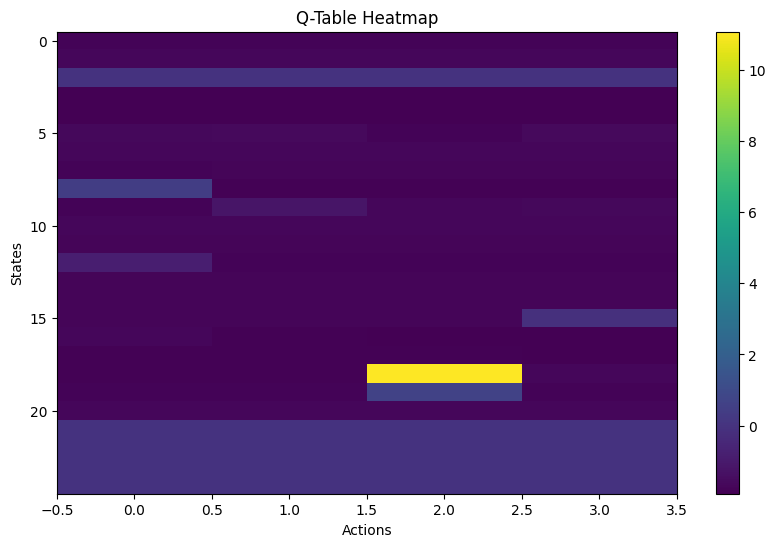

Agent 2 (Color: black) Q-table:
[[-1.73990604 -1.75255744 -1.75487702 -1.74621797]
 [-1.6646439  -1.70688366 -1.75559096 -0.07891198]
 [-0.1584253  -1.50833777 -1.47894441  4.5426518 ]
 [-1.52503845 -1.53463838 -1.51048154 11.0853036 ]
 [-1.81126424 -1.81569987 -1.59026309 -1.82939279]
 [-1.67905768 -1.55390903 -1.57150971 -1.54927539]
 [-1.15314681 -1.54042805 -1.6956166  -1.33198285]
 [-0.40249408 -0.72528828 -0.7311462  -0.53786465]
 [-1.08738901 -1.60972349 -1.7187072  -1.60000566]
 [-1.5666575  -1.29043331 -1.34095172 -1.44763297]
 [-1.38295884 -1.40071881 -1.37173166 -1.36215976]
 [ 0.57591156 -1.52795361 -1.44761487 -1.44822697]
 [-1.74309741 -0.44627057 -1.65514438 -1.60784435]
 [-1.49874471 -1.49281936 -1.52912674 -1.47023605]
 [-1.42463012 -1.38365529 -1.41342286 -1.46289635]
 [-1.46965814 -1.46826771 -1.47787868 -1.54624781]
 [-1.83236966 -1.86135213 -1.84596837 -1.85641263]
 [-0.88003583 -0.83009043 -0.96879478 -0.98127716]
 [-1.38114174 -1.35907538 -1.36303368 -1.41730911]

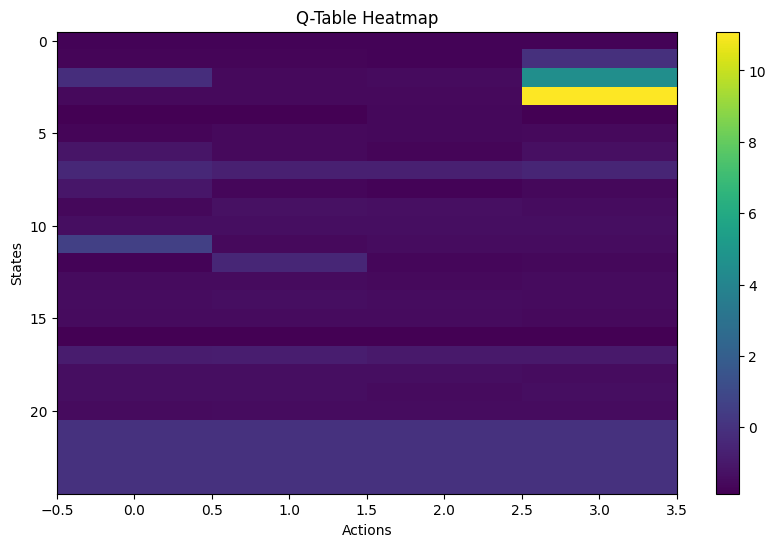

Experiment 3 with SARSA (Learning Rate: 0.45):
Experiment: 100 Iteration: 0
Experiment: 2 Iteration: 100
Experiment: 2 Iteration: 200
Experiment: 2 Iteration: 300
Experiment: 2 Iteration: 400
Experiment: 2 Iteration: 500
Experiment: 2 Iteration: 600
Experiment: 2 Iteration: 700
Experiment: 2 Iteration: 800
Experiment: 2 Iteration: 900
Experiment: 2 Iteration: 1000
Experiment: 2 Iteration: 1100
Experiment: 2 Iteration: 1200
Experiment: 2 Iteration: 1300
Experiment: 2 Iteration: 1400
Experiment: 2 Iteration: 1500
Experiment: 2 Iteration: 1600
Experiment: 2 Iteration: 1700
Experiment: 2 Iteration: 1800
Experiment: 2 Iteration: 1900
Experiment: 2 Iteration: 2000
Experiment: 2 Iteration: 2100
Experiment: 2 Iteration: 2200
Experiment: 2 Iteration: 2300
Experiment: 2 Iteration: 2400
Experiment: 2 Iteration: 2500
Experiment: 2 Iteration: 2600
Experiment: 2 Iteration: 2700
Experiment: 2 Iteration: 2800
Experiment: 2 Iteration: 2900
Experiment: 2 Iteration: 3000
Experiment: 2 Iteration: 3100
Exp

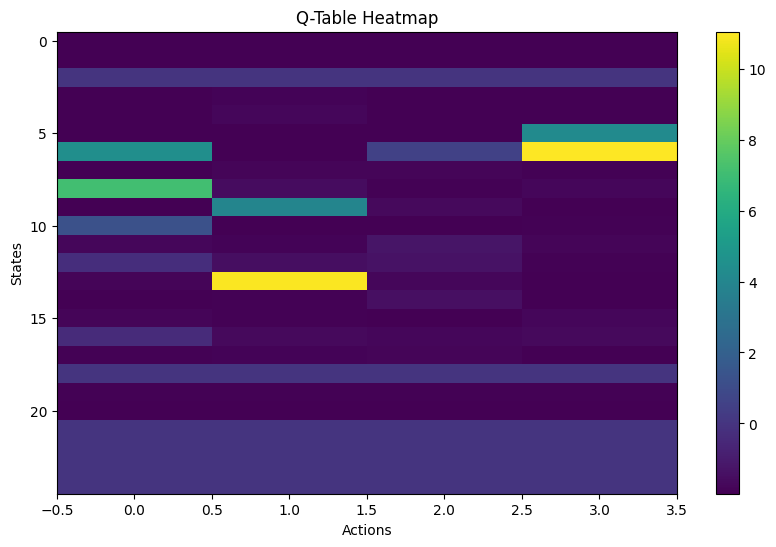

Agent 1 (Color: blue) Q-table:
[[-1.99586032 -1.99485091 -1.99500901 -1.99550559]
 [-1.99502586 -1.99517886 -1.99609891 -1.99578794]
 [ 0.          0.          0.          0.        ]
 [-1.99869876 -1.99892735 -1.99892192 -1.99896569]
 [-1.99905102 -1.99900895 -1.99915204 -1.99902867]
 [-1.9957604  -1.99625107 -1.99438437 -1.99497363]
 [-1.99642369 -1.99574169 -1.99638925 -1.9964339 ]
 [-1.99188417 -1.99235154 -1.99065695 -1.99175976]
 [ 1.21838494 -1.99829414 -1.9985445  -1.99833433]
 [-1.99642577 -1.99703812 -1.99628256 -1.99616762]
 [-1.99652299 -1.9967975  -1.99656498 -1.94419102]
 [-1.99748979 -1.99745368 -1.99700209 -1.96261181]
 [-1.99856784 -1.99818588 -1.99824004 -1.9982012 ]
 [-1.99686508 -1.99779765 -1.99754649 -1.99719916]
 [-1.99778204 -1.99835426 -1.99813142 -1.99839262]
 [-1.99847353 -1.99858211 -1.99851967 -1.9983558 ]
 [-1.99907259 -1.99912491 -1.9991003  -1.99922752]
 [-1.99837538 -1.99846725 -1.99852051 -1.99841059]
 [-1.998704   -1.99891673 11.00073975 -1.99867256]


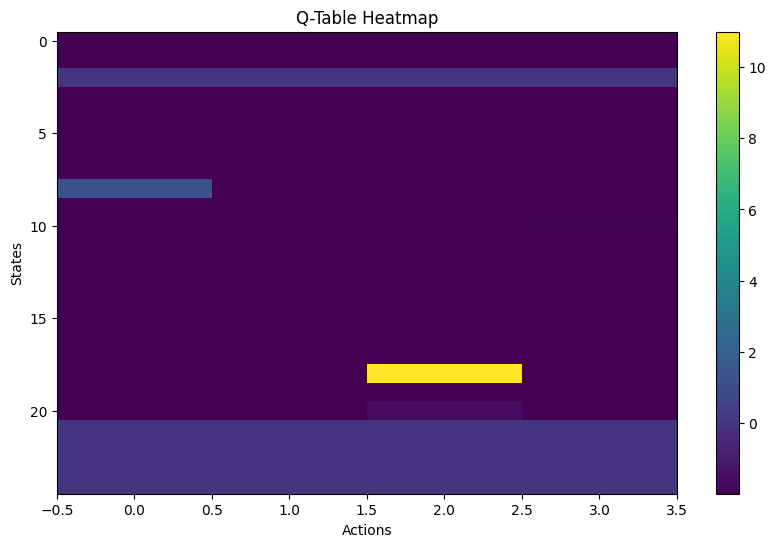

Agent 2 (Color: black) Q-table:
[[-1.98877086 -1.98103159 -1.98949158 -1.9895768 ]
 [-1.99434968 -1.99437353 -1.99412951 -0.53858676]
 [-0.89371229 -1.99524889 -1.9956786   4.5028011 ]
 [ 4.24437981 -1.92803348  0.44989924 11.00560221]
 [-1.98553896 -1.98162469 -1.9835533  -1.98879559]
 [-1.98981417 -1.9941596  -1.99088027 -1.9903974 ]
 [-1.58650437 -1.99105363 -1.99340024 -1.99229668]
 [-1.75118456 -1.83716119 -1.80136545 -1.75276874]
 [-1.98446866 -1.9839033  -1.98570187 -1.98525466]
 [-1.99402146 -1.78597388 -1.85744241 -1.99240979]
 [-1.99303706 -1.99050074 -1.99172579 -1.98964839]
 [-1.99354099 -1.99360101 -1.99408279 -1.9426067 ]
 [-1.98540296 -1.98576717 -1.98378049 -1.98380138]
 [-1.95884614 -1.94770127 -1.96594271 -1.98704894]
 [-1.98839103 -1.99389915 -1.98822632 -1.9896853 ]
 [-1.98726723 -1.98873578 -1.991466   -1.98558165]
 [-1.97602207 -1.99310033 -1.9846067  -1.99138506]
 [-1.83571433 -1.88966698 -1.92438465 -1.88642603]
 [-1.99375316 -1.99046765 -1.94271758 -1.9909434 ]

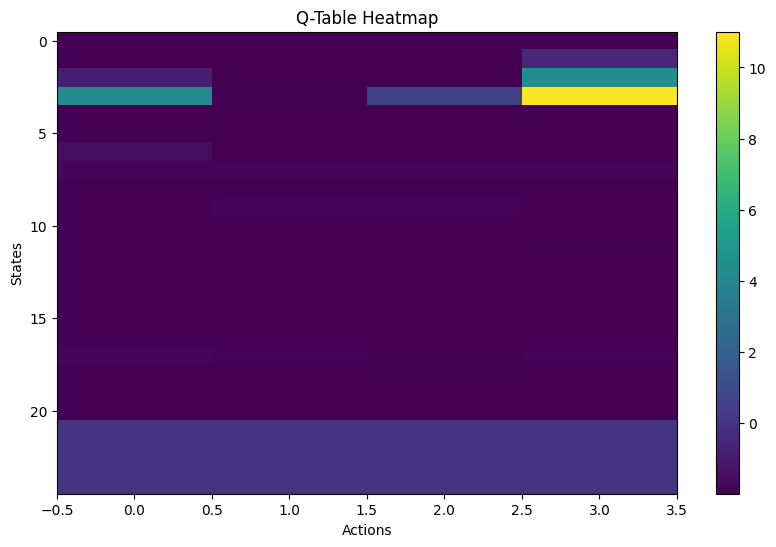

In [14]:
learning_rates = [0.15, 0.45]

# Experiment 3 with Q-learning
for i, alpha in enumerate(learning_rates):
    print(f"Experiment 3 with Q-learning (Learning Rate: {alpha}):")
    q_learning_agents = [QLearningAgent(num_actions=4, learning_rate=alpha, discount_factor=0.5) for _ in range(env.num_agents)]
    train_agents(env, q_learning_agents, num_iterations=9000, policy='PEXPLOIT')
    
    # Print heatmap for Q-learning agents
    for agent_id, agent in enumerate(q_learning_agents):
        agent_color = env.agent_colors[agent_id]
        print(f"Agent {agent_id} (Color: {agent_color}) Q-table:")
        print(agent.q_table)
        plot_q_table_heatmap(agent.q_table)

# Experiment 3 with SARSA
for i, alpha in enumerate(learning_rates):
    print(f"Experiment 3 with SARSA (Learning Rate: {alpha}):")
    sarsa_agents = [SARSAQAgent(num_actions=4, learning_rate=alpha, discount_factor=0.5) for _ in range(env.num_agents)]
    train_agents(env, sarsa_agents, num_iterations=9000, policy='SARSA')
    
    # Print heatmap for SARSA agents
    for agent_id, agent in enumerate(sarsa_agents):
        agent_color = env.agent_colors[agent_id]
        print(f"Agent {agent_id} (Color: {agent_color}) Q-table:")
        print(agent.q_table)
        plot_q_table_heatmap(agent.q_table)

Experiment 4:
Iteration: 0
Iteration: 100
Iteration: 200
Iteration: 300
Iteration: 400
Iteration: 500
Iteration: 600
Iteration: 700
Iteration: 800
Iteration: 900
Iteration: 1000
Iteration: 1100
Iteration: 1200
Iteration: 1300
Iteration: 1400
Iteration: 1500
Iteration: 1600
Iteration: 1700
Iteration: 1800
Iteration: 1900
Iteration: 2000
Iteration: 2100
Iteration: 2200
Iteration: 2300
Iteration: 2400
Iteration: 2500
Iteration: 2600
Iteration: 2700
Iteration: 2800
Iteration: 2900
Iteration: 3000
Iteration: 3100
Iteration: 3200
Iteration: 3300
Iteration: 3400
Iteration: 3500
Iteration: 3600
Iteration: 3700
Iteration: 3800
Iteration: 3900
Iteration: 4000
Iteration: 4100
Iteration: 4200
Iteration: 4300
Iteration: 4400
Iteration: 4500
Iteration: 4600
Iteration: 4700
Iteration: 4800
Iteration: 4900
Iteration: 5000
Iteration: 5100
Iteration: 5200
Iteration: 5300
Iteration: 5400
Iteration: 5500
Iteration: 5600
Iteration: 5700
Iteration: 5800
Iteration: 5900
Iteration: 6000
Iteration: 6100
Iterat

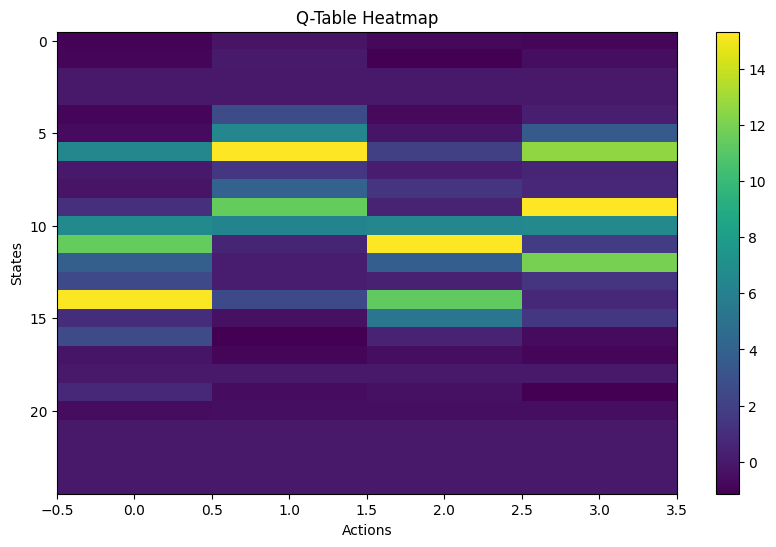

Agent 1 (Color: blue) Q-table:
[[-1.15456937e+00 -1.19781933e+00 -1.13704068e+00 -3.87220677e-01]
 [-5.94229391e-01 -4.11626127e-01  3.76330868e-01 -1.62664926e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.24543890e+00 -6.99961579e-01 -1.30887811e+00 -1.20162744e+00]
 [-7.21676653e-01  2.35066554e+00 -7.31192136e-01 -8.97765237e-01]
 [-2.16451243e-01  2.25955088e+00  1.52907187e-01  7.95034667e-01]
 [-2.35199610e-01  4.59991191e-03 -3.97558384e-01 -4.75766620e-01]
 [-1.32891204e+00  1.49892438e+00 -1.31433804e-01 -1.11137547e+00]
 [-3.36975613e-01 -4.01385805e-01 -5.79937242e-01  2.29059824e+00]
 [-1.42755701e-01  2.38222905e+00  6.34107317e+00  8.62822354e+00]
 [-4.63256673e-01  2.83088400e+00  2.86589265e+00  9.35171607e-01]
 [ 6.24752672e+00  3.44641935e-01  3.06562112e+00  4.69937698e-01]
 [-5.95104046e-01  9.22035773e-01 -2.80775590e-01  8.48993710e-01]
 [ 1.51779947e+00 -5.75071729e-01  1.54689871e-01  1.95024333e+00]
 [ 5.59155318e+00  1.73586138e+

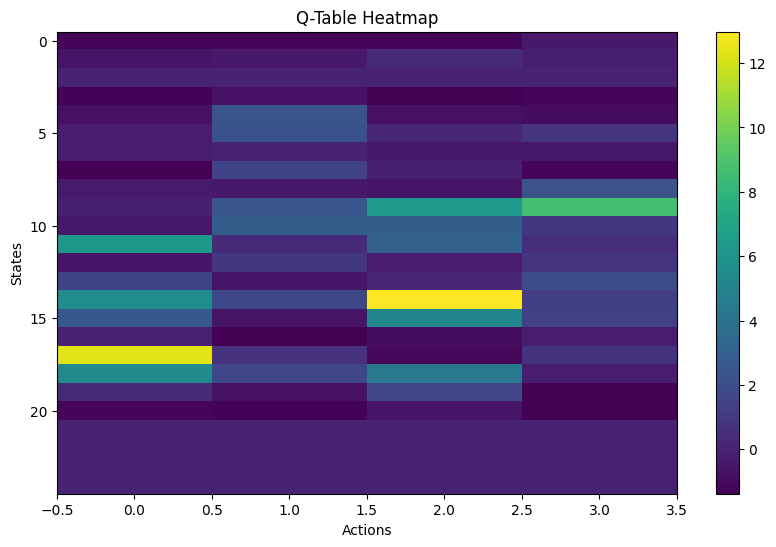

Agent 2 (Color: black) Q-table:
[[-1.37291809e+00 -1.32795560e+00 -1.28455088e+00 -1.18798628e+00]
 [-1.00994678e+00 -8.31674002e-01 -1.46274000e+00  2.12460883e-01]
 [-4.40591121e-01  4.89763289e+00 -1.09075866e+00 -3.44049823e-01]
 [-3.02927832e-01 -3.32076582e-01 -5.31954239e-01 -1.25923481e+00]
 [-1.46621567e+00  9.17958947e-01 -1.36301933e+00 -1.28580723e+00]
 [-1.13395944e+00 -9.11507163e-01 -1.42140332e+00  2.57850078e+00]
 [ 1.27602404e-01 -4.13791815e-02 -4.39948662e-01  1.17952658e+01]
 [-4.09468441e-01 -8.29616250e-01 -1.05012937e+00 -6.88271427e-01]
 [-1.42372753e+00 -8.00106514e-01 -1.30046017e+00 -1.28025820e+00]
 [-1.21827113e+00 -1.07659338e+00 -1.11211383e+00 -9.17505282e-01]
 [ 1.85094497e-01 -2.90896930e-02  3.20431916e-03  2.11180360e-01]
 [-7.83614661e-01 -1.17260858e+00  6.14619847e-01 -1.29944314e+00]
 [-1.33011059e+00  1.30193494e+00 -1.31158820e+00 -1.40894752e+00]
 [ 1.17489232e+00 -9.19998488e-01 -9.22575491e-01 -2.83087369e-01]
 [-1.14233694e+00 -1.43034198e

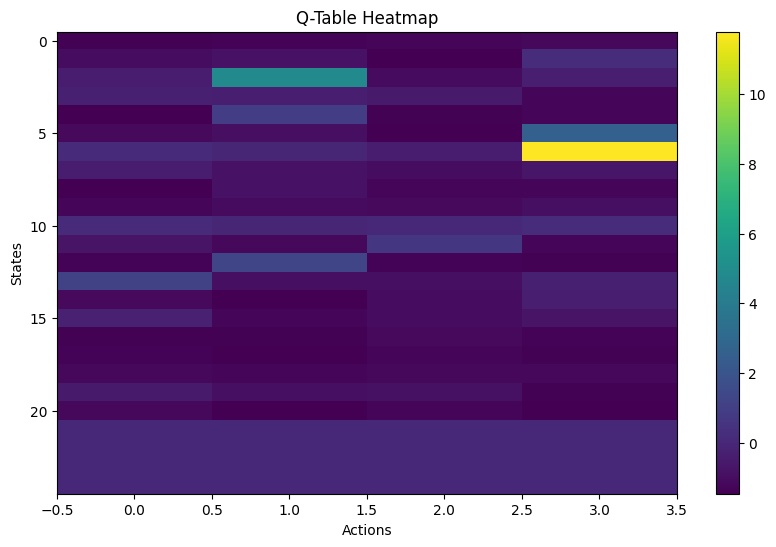

In [15]:
def train_agents_exp4(env, agents, num_iterations, policy):
    terminal_state_count = 0  # Track the number of times terminal state is reached
    for iteration in range(num_iterations):
        env.reset()  # Reset the PD world to initial state
        for agent_id in range(env.num_agents):
            agent = agents[agent_id]
            state = env.get_state(agent_id)
            total_reward = 0
            action = None  # Initialize action for SARSA

            for _ in range(100):  
                if policy == 'SARSA':
                    next_action = agent.choose_action(state, policy)  # Get next action for SARSA
                action = agent.choose_action(state, policy)  # Get action for Q-learning or SARSA
                reward = env.move_agent(agent_id, action)
                next_state = env.get_state(agent_id)
                total_reward += reward
                if policy == 'SARSA':
                    agent.update_q_table(state, action, reward, next_state, next_action)  # Provide next_action for SARSA
                else:
                    agent.update_q_table(state, action, reward, next_state)
                state = next_state
                if total_reward > 0:  
                    break

            agent.decay_exploration_rate()

            # Check for terminal state and update pickup locations after the third terminal state
            if total_reward > 0:
                terminal_state_count += 1
                if terminal_state_count == 3:
                    env.pickup_locations = [(4, 2), (3, 3), (2, 4)]

            if terminal_state_count == 6:
                break

        if iteration % 100 == 0:
            print("Iteration:", iteration)

env = Environment()
agents = [QLearningAgent(num_actions=4, learning_rate=0.3, discount_factor=0.5) for _ in range(env.num_agents)]

# Experiment 4
print("Experiment 4:")
train_agents_exp4(env, agents, num_iterations=10000, policy='PRANDOM')  # Initial training with PRANDOM for 500 steps
train_agents_exp4(env, agents, num_iterations=15000, policy='PEXPLOIT')  # Continue with PEXPLOIT

# Print Q-tables and heatmaps after Experiment 4
print("Q-tables after Experiment 4:")
for agent_id, agent in enumerate(agents):
    agent_color = env.agent_colors[agent_id]  # Get the color of the current agent
    print(f"Agent {agent_id} (Color: {agent_color}) Q-table:")
    print(agent.q_table)
    plot_q_table_heatmap(agent.q_table)